In [1]:
# For data
import numpy as np
import pandas as pd
from pandas import factorize

In [2]:
# For data visualization
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rc('legend', fontsize= 20)    
plt.rc('figure', titlesize= 20) 
import seaborn as sns

In [3]:
# For interactive plots
import chart_studio.plotly as py
from plotly.offline import plot, iplot
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio

In [4]:
# For model pre-processing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OrdinalEncoder

In [5]:
# For Machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# For model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [7]:
# General
import pickle
import warnings   # To ignore any warnings 
warnings.filterwarnings("ignore")
%matplotlib inline 

In [8]:
Loan_Applications = pd.read_excel('loans_file.xlsx')

In [9]:
Loan_Applications = Loan_Applications.loc[0:2011, :] # Row no.2012 is the sum of some columns
Loan_Applications.shape[0]

2012

In [10]:
Loan_Applications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 14 columns):
District              2012 non-null object
Gender                2012 non-null object
Ownership             2012 non-null object
Age                   2012 non-null float64
Age Range             2012 non-null object
Country               2012 non-null object
Business Status       2012 non-null object
Field                 2012 non-null object
Consultant            2010 non-null object
Loan Amount           870 non-null float64
Debt Arrangement      2010 non-null float64
In legal treatment    1997 non-null float64
Default               2006 non-null float64
Delay over 90 days    2008 non-null float64
dtypes: float64(6), object(8)
memory usage: 220.2+ KB


Although it seems as if there are 870 loans and thousands of 'risky' loans ('In legal treatment'/'default' and so on), in the excel column of 'Loan Amount' cell with no loans amount are empty, in the other columns the cell has the variable 0 as int. So the info counts them. Later on, I will focus only on loans and 'risky' loans with a cell value greater than 0.	 

In [11]:
Loan_Applications.head(4)

,District,Gender,Ownership,Age,Age Range,Country,Business Status,Field,Consultant,Loan Amount,Debt Arrangement,In legal treatment,Default,Delay over 90 days
0,North,M,Multiple Owners,63.0,60 - 70,USA,New Business,Food and restaurants,A.D,125000.0,0.0,0.0,127110.0,0.0
1,Center,M,One Owner,37.0,30 - 40,Uzbekistan,New Business,Food and restaurants,S.S,100000.0,6339.0,0.0,0.0,0.0
2,Center,M,One Owner,25.0,20 - 30,Iran,Old Business,Fashion,M.G,125000.0,0.0,0.0,110514.0,0.0
3,South,F,One Owner,51.0,50 - 60,France,Old Business,Professional Services,P.C,NaN,0.0,0.0,0.0,0.0


From the data frame of the loans applications, I will take only the data of approved applications, that is data of loans taken

In [12]:
loans = Loan_Applications[Loan_Applications['Loan Amount'] > 0]
loans['Loan Amount'].describe()

count       870.000000
mean      74750.517241
std       34046.039401
min       10000.000000
25%       50000.000000
50%       70000.000000
75%      100000.000000
max      125000.000000
Name: Loan Amount, dtype: float64

# Preparing the data for analysis and later on - building machine learning model

Create a new column-'Repaid' with the value 'N' where there is a loan amount in columns that indicate that the loan isn't repaid, and 'Y' otherwise.
Create another column-'Bad Debt Amount' that takes the value of one of the columns/cases that indicate that the loan isn't repaid. 

In [13]:
loans['Repaid'] = 'NaN'
loans['Bad Debt Amount']=loans.loc[:,['Debt Arrangement',"In legal treatment", "Default","Delay over 90 days"]].sum(axis=1)
loans['Repaid'] = np.where(loans['Bad Debt Amount'] > 0, 'N', 'Y')

Get a list of consultants who have submitted at least 15 approved credit applications

In [14]:
freq_consultants = loans.groupby('Consultant')['Consultant'].agg('count').sort_values(ascending=False)
other_consultants = freq_consultants[freq_consultants < 15]
loans['Consultant'] = loans['Consultant'].apply(lambda x: 'Other' if x in other_consultants else x)

Create a dictionary of the stats of Former USSR in order to combine it as the same area

In [15]:
USSR_keys = ['Armenia', 'Azerbaijan', 'Belarus', 'Estonia', 'Georgia', 'Kazakhstan', 'Kyrgyzstan', 'Latvia',
              'Lithuania','Moldova', 'Russia', 'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan','CVCZ']
USSR_vals = ['Former USSR' for i in USSR_keys]
USSR_dict = dict(zip(USSR_keys, USSR_vals))

In [16]:
for k in USSR_dict:
    loans['Country'].replace(k, USSR_dict[k], inplace=True)

Get a list of business locations (Countries) who have submitted at least 10 approved credit applications

In [17]:
freq_countries = loans.groupby('Country')['Country'].agg('count').sort_values(ascending=False)
other_countries = freq_countries[freq_countries < 10]
loans['Country'] = loans['Country'].apply(lambda x: 'Other' if x in other_countries else x)

Create a new column that separate the loans into 5 categories by their amount.
Then we can check if the "bad" loans are corrolated with the amount of a loans

In [18]:
bins=[0,25000,50000,75000,100000, 125000] 
groups=['Very Low','Low','Medium','High', 'Very High'] 
loans['Loan Amount Range']=pd.cut(loans['Loan Amount'],bins,labels=groups)
loans.head()

,District,Gender,Ownership,Age,Age Range,Country,Business Status,Field,Consultant,Loan Amount,Debt Arrangement,In legal treatment,Default,Delay over 90 days,Repaid,Bad Debt Amount,Loan Amount Range
0,North,M,Multiple Owners,63.0,60 - 70,USA,New Business,Food and restaurants,Other,125000.0,0.0,0.0,127110.0,0.0,N,127110.0,Very High
1,Center,M,One Owner,37.0,30 - 40,Former USSR,New Business,Food and restaurants,S.S,100000.0,6339.0,0.0,0.0,0.0,N,6339.0,High
2,Center,M,One Owner,25.0,20 - 30,Iran,Old Business,Fashion,M.G,125000.0,0.0,0.0,110514.0,0.0,N,110514.0,Very High
5,Center,F,One Owner,38.0,30 - 40,Former USSR,Old Business,Other,A.S,75000.0,0.0,0.0,0.0,0.0,Y,0.0,Medium
12,Center,F,One Owner,35.0,30 - 40,England,New Business,Production,Other,125000.0,0.0,0.0,0.0,0.0,Y,0.0,Very High


Show a summary of information of 'bad' loans

In [19]:
bad_loans = loans[(loans["Repaid"] == 'N')]
bad_loans.describe().round(decimals=0).apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Age,Loan Amount,Debt Arrangement,In legal treatment,Default,Delay over 90 days,Bad Debt Amount
count,186,186,186,186,186,186,186
mean,40,75369,10104,28890,15917,4971,59881
std,10,33643,28043,40235,32896,14968,36436
min,22,15000,0,0,0,0,0
25%,31,50000,0,0,0,0,32603
50%,40,70000,0,0,0,0,54098
75%,48,100000,0,52377,0,0,82273
max,63,125000,127040,177291,131976,83031,177291


# Data analysis -  Exploring the data ...

Plot total of 'risky' loans vs 'good' loans 

Text(0.5, 1.0, 'Distribution Of Data By Loan Status')

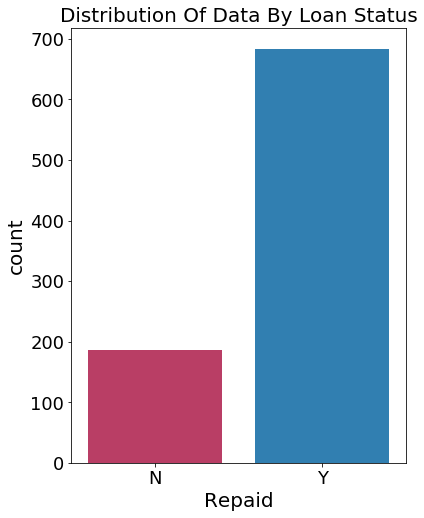

In [20]:
fig = plt.figure(figsize = (6,8))
sns.countplot(x='Repaid', data=loans, palette=['#ce295e','#1c84c6'])
plt.title('Distribution Of Data By Loan Status')
#plt.savefig('PaidYN.png', bbox_inches = 'tight')

# The target values are Imbalanced. I will deal with that in the section of building the machine learning model below

Plot two distribution plot: One of the total loans, and the other only for 'bad' loans

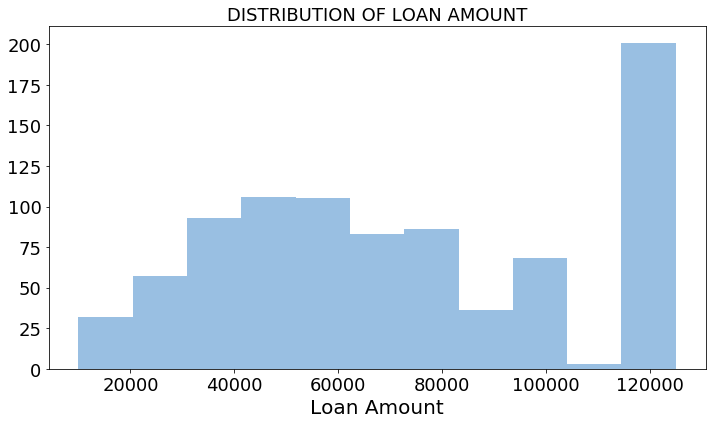

In [21]:
fig = plt.figure(figsize=(10,6))
sns.distplot(loans['Loan Amount'], norm_hist=False, kde=False, color= '#0060b8')

plt.title('DISTRIBUTION OF LOAN AMOUNT', fontsize=18)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
# plt.savefig('distLoansAmount2.png', bbox_inches='tight')

Most of the loans are in the amount of 40k to 80K, where there are more than 200 loans (~23% of total of 870) are in the amount of 120K

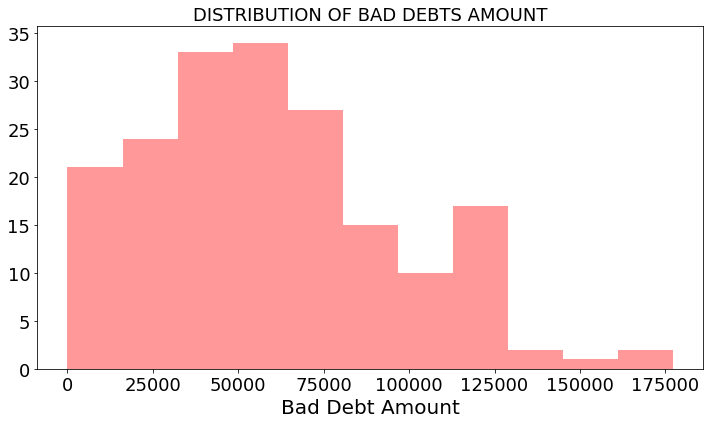

In [22]:
fig = plt.figure(figsize=(10,10))
sns.distplot(loans['Bad Debt Amount'][loans['Repaid'] == 'N'], norm_hist=False, kde=False, color='red')

plt.title('DISTRIBUTION OF BAD DEBTS AMOUNT', fontsize=18)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
# plt.savefig('distDebtsAmount2.png', bbox_inches='tight')

Surprisingly, most "bad" loans are in the small amount of 20K to 75K. There are few 'bad' loans in excess of 100K. At this point it should be noted that while the highest amount of the loans is ~ 120,000, the amount of debt is higher because of high interest rates when the loan is not repaid

Check the 'bad' debts distribution

In [23]:
debts_cols = ['Loan Amount', 'Debt Arrangement', 'In legal treatment', 'Default','Delay over 90 days', 'Bad Debt Amount']
count = loans[loans[debts_cols] > 0][debts_cols].count()
sum_ = loans[loans[debts_cols] > 0][debts_cols].sum().round(decimals=0)

In [24]:
debts = pd.DataFrame({'COUNT': count, 'SUM': sum_}, index = debts_cols).astype(int).round(0)
debts['BY SUM %'] = ((debts['SUM']/debts.loc['Loan Amount','SUM']) * 100).round(decimals=1)
debts['BY COUNT %'] = ((debts['COUNT']/debts.loc['Loan Amount','COUNT']) * 100).round(decimals=1)
debts

,COUNT,SUM,BY SUM %,BY COUNT %
Loan Amount,870,65032950,100.0,100.0
Debt Arrangement,26,1879263,2.9,3.0
In legal treatment,93,5373499,8.3,10.7
Default,43,2960496,4.6,4.9
Delay over 90 days,24,924602,1.4,2.8
Bad Debt Amount,186,11137860,17.1,21.4


In [25]:
# Spliting the data to 'good' and 'bad' loans, before plotting two donats plots 
good_value = debts['SUM'][0]- debts['SUM'][-1]
bad_value = debts['SUM'][-1]
total_values = [good_value, debts['SUM'][1], debts['SUM'][2], debts['SUM'][3], debts['SUM'][4]]

In [26]:
# 2 donats plots of loans data - good loans and bad loans
loans_data = [# Portfolio (inner donut)
               go.Pie(values=[good_value, bad_value],  
                      labels=['Good Loans','Bad Debts'],
                      hole=0.3,
                      sort=False,
                      textfont=dict(size=20),
                      marker={'colors':['#1c84c6','#CB4335']}),

               # Individual components (outer donut)
              go.Pie(values=total_values,
                    labels=["Good Loans",'Debt Arrangement','In legal treatment','Lost Debt','Delay over 90 days'],
                    hole=0.75,
                    sort=False,
                    textfont=dict(size=18),
                    marker={'colors':['white','#EF7F73','#F1948A','#F4A9A1','#F6BEB8']},
                    showlegend=True)]

fig =go.Figure(data=loans_data)

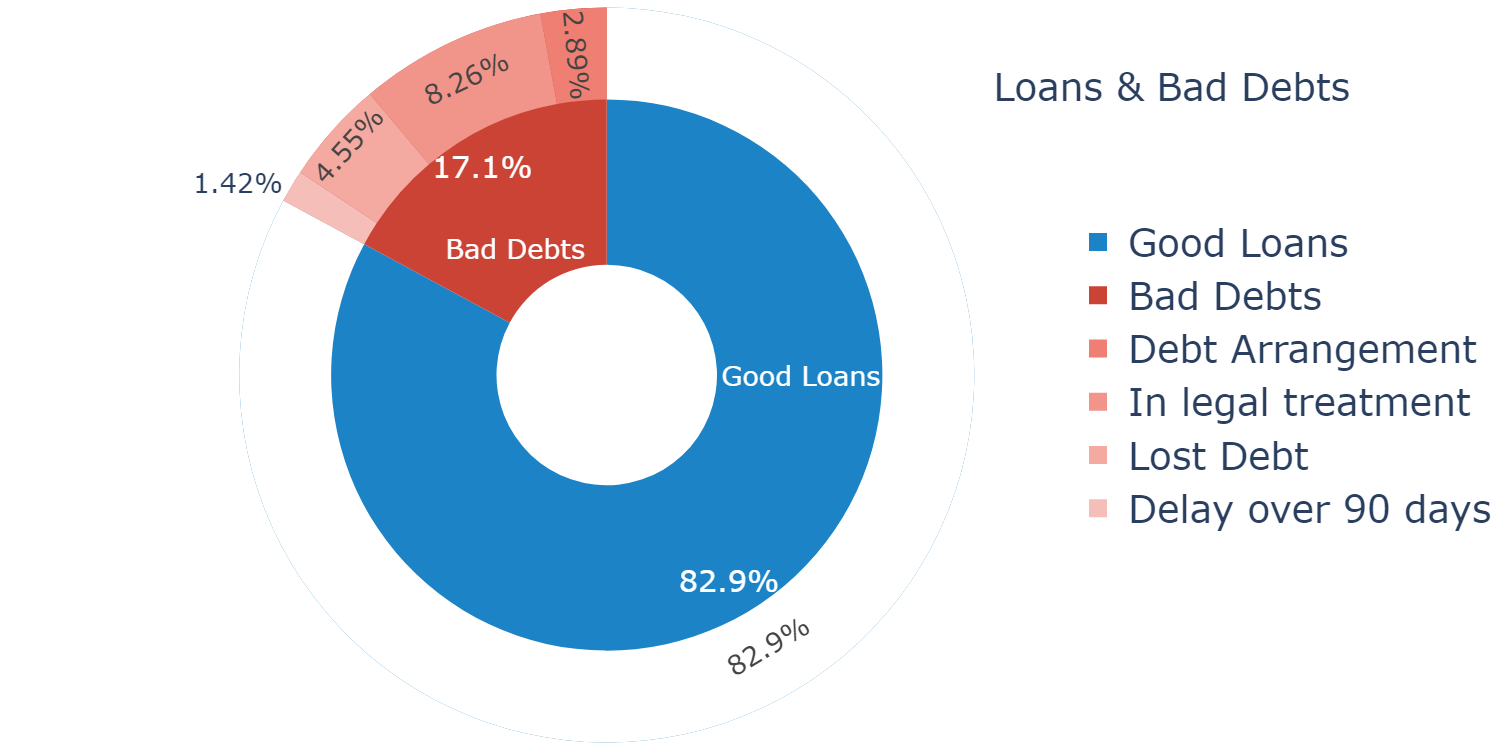

In [27]:
# Create / update the figure layout
fig.update_layout(
                  title={'text': "Loans & Bad Debts", 'y':0.9, 'x':0.9, 'font': {'size': 25}},
                  margin = dict(t=0, l=0, r=0, b=0),
                  legend=dict(font_size=25, x=1, y=0.5),
                  # Add annotations in the center of the donut pies.
                  annotations=[dict(text='Bad Debts', x=0.4, y=0.7, font_size=18, font_color = 'white', showarrow=False),
                  dict(text='Good Loans', x=0.8, y=0.5, font_size=18, font_color = 'white', showarrow=False)])

pio.write_html(fig, file='Pie_loans_fig.html', auto_open=False) # as interactive plot with .html page

# pio.show(fig) # to display on Jupyter notebook as interactive mode
pio.show(fig, renderer='png', width=1000, height=500, scale=1.5) # to display on github as a static figure

Plot the distribution of categorical columns to check for imbalance

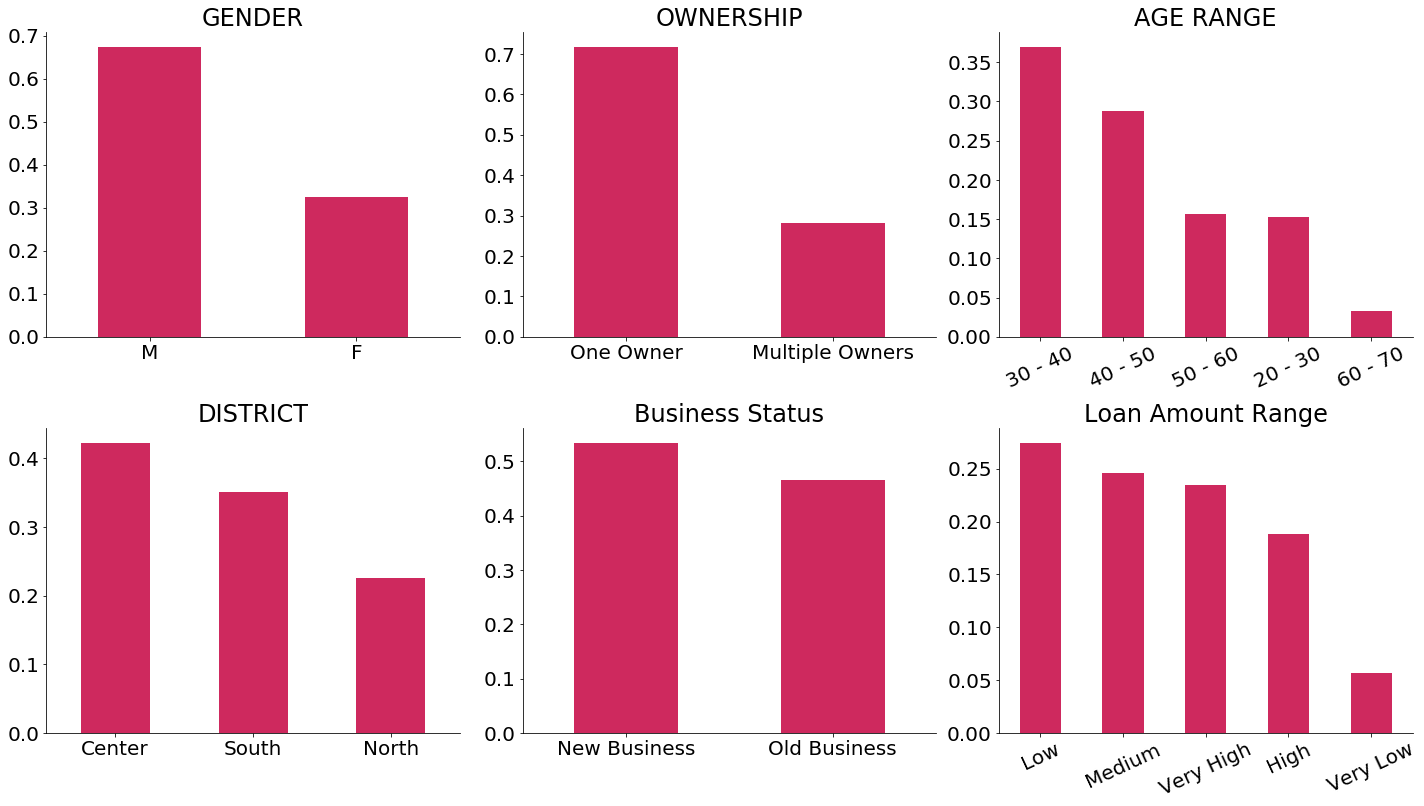

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

loans['Gender'].value_counts(normalize=True).plot.bar(ax=axes[0][0], fontsize=20 , color='#ce295e') 
axes[0][0].set_title("GENDER", fontsize=24)

loans['Ownership'].value_counts(normalize=True).plot.bar(ax=axes[0][1], fontsize=20, color='#ce295e') 
axes[0][1].set_title("OWNERSHIP", fontsize=24)

loans['Age Range'].value_counts(normalize=True).plot.bar(ax=axes[0][2], fontsize=20,  color='#ce295e') 
axes[0][2].set_title("AGE RANGE", fontsize=24)

loans['District'].value_counts(normalize=True).plot.bar(ax=axes[1][0], fontsize=20, color='#ce295e') 
axes[1][0].set_title("DISTRICT", fontsize=24)

loans['Business Status'].value_counts(normalize=True).plot.bar(ax=axes[1][1], fontsize=20, color='#ce295e') 
axes[1][1].set_title("Business Status", fontsize=24)

loans['Loan Amount Range'].value_counts(normalize=True).plot.bar(ax=axes[1][2], fontsize=20, color='#ce295e') 
axes[1][2].set_title("Loan Amount Range", fontsize=24)

sns.despine()
plt.setp(axes[0][0].get_xticklabels(), rotation=0)
plt.setp(axes[0][1].get_xticklabels(), rotation=0)
plt.setp(axes[0][2].get_xticklabels(), rotation=25)
plt.setp(axes[1][0].get_xticklabels(), rotation=0)
plt.setp(axes[1][1].get_xticklabels(), rotation=0)
plt.setp(axes[1][2].get_xticklabels(), rotation=25)
plt.gcf().set_size_inches(20, 12)
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=.3)

# plt.savefig('LoansByCategories2.png', bbox_inches='tight')

As we can see, some of the categories, such as gender, ownership, age are not balanced,
where district, business status and loan amount range are more balanced. At this point it should be stated, that the loan is given to one person, for a business that can be held by him and other owners. 
Now lets explore the data in each category

Count 'bad' loans by the loan amount range

In [29]:
CountLoansByRange = loans[['Loan Amount Range', 'Loan Amount']].groupby(['Loan Amount Range']).count()
CountDebtsByRange = bad_loans[['Loan Amount Range','Bad Debt Amount']].groupby(['Loan Amount Range']).count()
CountByRange = pd.concat([CountLoansByRange, CountDebtsByRange], axis=1)

In [30]:
CountByRange['Bad Debts %'] = (CountByRange['Bad Debt Amount']/CountByRange['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
CountByRange.rename(columns={'Loan Amount': 'Loan-Count','Bad Debt Amount':'Bad Debts-Count'}, inplace=True)
CountByRange.head()

,Loan-Count,Bad Debts-Count,Bad Debts %
Loan Amount Range,,,
Very Low,49,7,14.3%
Low,239,56,23.4%
Medium,214,44,20.6%
High,164,36,22.0%
Very High,204,43,21.1%


In [31]:
PaidByLoanRangeC=pd.crosstab(loans['Loan Amount Range'],loans['Repaid']) 
PaidByLoanRangeC

Repaid,N,Y
Loan Amount Range,,
Very Low,7,42
Low,56,183
Medium,44,170
High,36,128
Very High,43,161


<Figure size 1008x432 with 0 Axes>

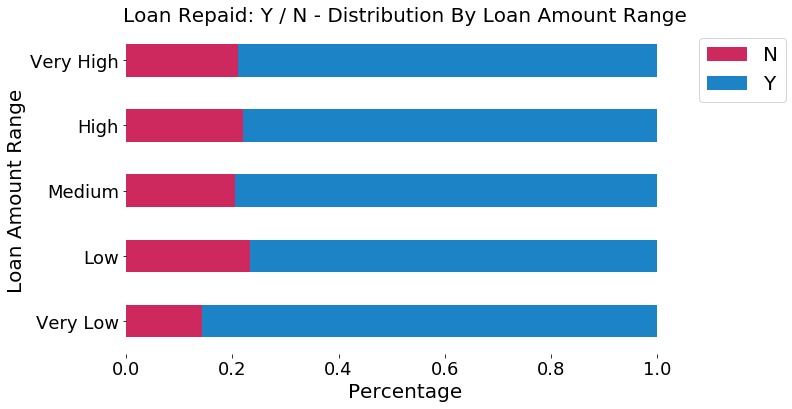

In [32]:
fig = plt.figure(figsize=(14,6))

PaidByLoanRangeC.div(PaidByLoanRangeC.sum(1).astype(float), axis=0).plot(kind="barh",stacked=True,color=['#ce295e','#1c84c6']) 

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Loan Amount Range') 
plt.title('Loan Repaid: Y / N - Distribution By Loan Amount Range')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.gcf().set_size_inches(10, 6)
#plt.savefig('PaidByLoanRangeFig.png', bbox_inches = 'tight')

The highest rate of 'bad' debts is in the range of low amount of loan - 25K to 50K

Calculate average loan amount by business status

In [33]:
avgLoanByBusiness = loans[['Business Status','Loan Amount']].groupby(['Business Status']).mean().astype(int)
avgLoanByBusiness

,Loan Amount
Business Status,
New Business,75817
Old Business,73525


There seems to be no different of the mean amount of loan between new business and old business

Count 'bad' loans by the business status

In [34]:
CountLoansByBusiness = loans[['Business Status', 'Loan Amount']].groupby(['Business Status']).count()
CountDebtsByBusiness = bad_loans[['Business Status','Bad Debt Amount']].groupby(['Business Status']).count()
CountByBusiness = pd.concat([CountLoansByBusiness, CountDebtsByBusiness], axis=1)

In [35]:
CountByBusiness['Bad Debts %'] = (CountByBusiness['Bad Debt Amount']/CountByBusiness['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
CountByBusiness.rename(columns={'Loan Amount': 'Loan-Count','Bad Debt Amount':'Bad Debts-Count'}, inplace=True)
CountByBusiness.head()

,Loan-Count,Bad Debts-Count,Bad Debts %
Business Status,,,
New Business,465,106,22.8%
Old Business,405,80,19.8%


The percentage of bad debts by count is also 3% higher for new business than for old business. Now let's plot it

In [36]:
PaidByLoanBusinessC=pd.crosstab(loans['Business Status'],loans['Repaid']) 
PaidByLoanBusinessC

Repaid,N,Y
Business Status,,
New Business,106,359
Old Business,80,325


<Figure size 1008x432 with 0 Axes>

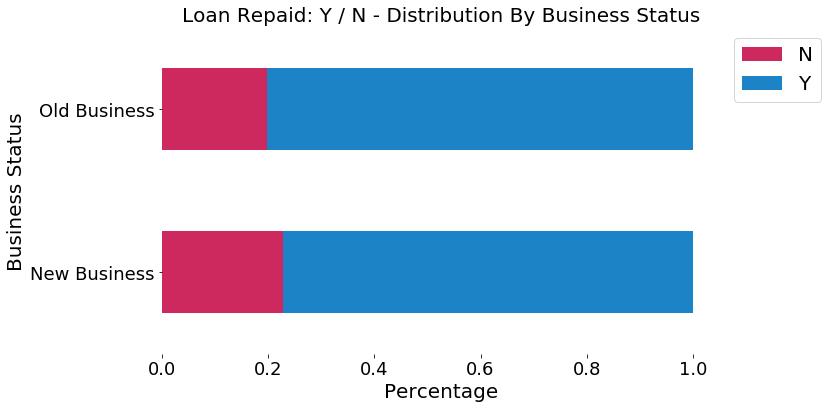

In [37]:
fig = plt.figure(figsize=(14,6))

PaidByLoanBusinessC.div(PaidByLoanBusinessC.sum(1).astype(float), axis=0).plot(kind="barh",stacked=True, 
                                                                               color=['#ce295e','#1c84c6']) 

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Business Status') 
plt.title('Loan Repaid: Y / N - Distribution By Business Status')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.gcf().set_size_inches(10, 6)
# plt.savefig('PaidByLoanBusinessFig.png', bbox_inches = 'tight')

Loans by district.   First calculate the average loan amount by district

In [38]:
avgLoanByDistrict = loans[['District','Loan Amount']].groupby(['District']).mean().astype(int)
avgLoanByDistrict

,Loan Amount
District,
Center,81072
North,77076
South,65657


The highest average loan amount is in the center - 81k and the lowest is in the south - 66k . 
Lets plot loan amount by district

<Figure size 720x432 with 0 Axes>

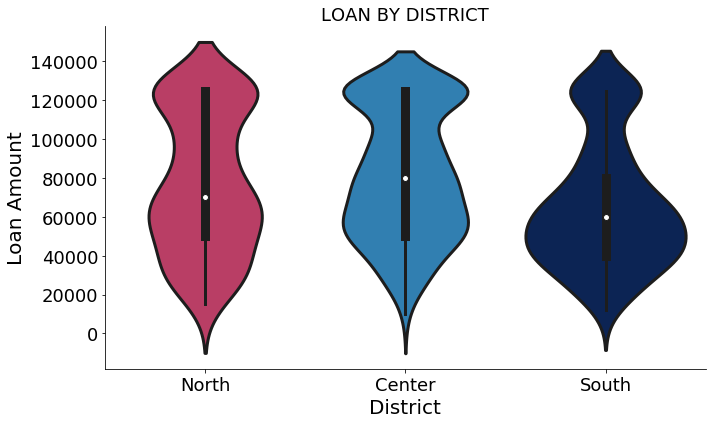

In [39]:
fig = plt.figure(figsize=(10,6))
sns.catplot(x="District", y='Loan Amount', kind="violin", data=loans, palette=['#ce295e','#1c84c6','#002060'])
plt.title('LOAN BY DISTRICT', fontsize=18)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
# plt.savefig('LoanByDistrict.png', bbox_inches='tight')

'Bad' debts by district. First by total loans amount

In [40]:
DebtsByDistrict = loans[['District','Loan Amount','Bad Debt Amount']].groupby(['District']).sum().astype(int)
DebtsByDistrict['Bad Debts %'] = (DebtsByDistrict['Bad Debt Amount']/DebtsByDistrict['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
DebtsByDistrict.head()

,Loan Amount,Bad Debt Amount,Bad Debts %
District,,,
Center,29834650,5025224,16.8%
North,15107000,2557414,16.9%
South,20091300,3555221,17.7%


There is not much difference between the districts.
Now let's look at the loans count, a more representative figure

In [41]:
CountLoansByDistrict = loans[['District', 'Loan Amount']].groupby(['District']).count()
CountDebtsByDistrict = bad_loans[['District','Bad Debt Amount']].groupby(['District']).count()
CountByDistrict = pd.concat([CountLoansByDistrict, CountDebtsByDistrict], axis=1)

In [42]:
CountByDistrict['Bad Debts %'] = (CountByDistrict['Bad Debt Amount']/CountByDistrict['Loan Amount'])\
                                  .astype(float).map("{:.1%}".format)
CountByDistrict.rename(columns={'Loan Amount': 'Loan-Count','Bad Debt Amount':'Bad Debts-Count'}, inplace=True)
CountByDistrict.head()

,Loan-Count,Bad Debts-Count,Bad Debts %
District,,,
Center,368,76,20.7%
North,196,38,19.4%
South,306,72,23.5%


The highest percentage of 'bad' debts is in the south, and the lowest is in the north.
Lets plot it

In [43]:
PaidByDistrict=pd.crosstab(loans['District'],loans['Repaid']) 
PaidByDistrict

Repaid,N,Y
District,,
Center,76,292
North,38,158
South,72,234


<Figure size 1008x432 with 0 Axes>

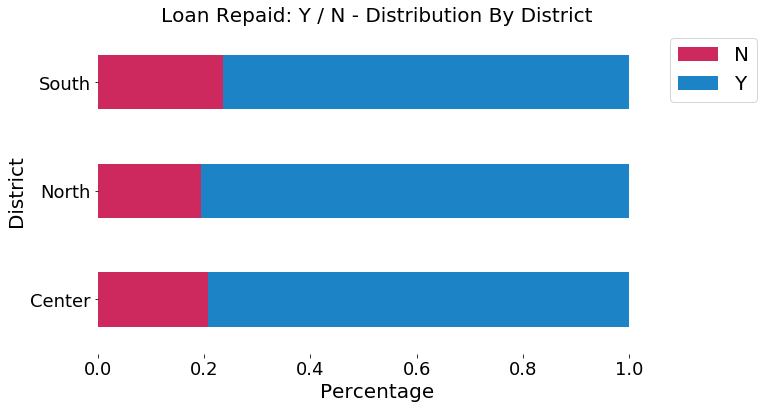

In [44]:
fig = plt.figure(figsize=(14,6))

PaidByDistrict.div(PaidByDistrict.sum(1).astype(float), axis=0).plot(kind="barh", stacked=True, color=['#ce295e','#1c84c6'])

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Percentage', fontsize=20)
plt.ylabel('District', fontsize=20)
plt.title('Loan Repaid: Y / N - Distribution By District')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.gcf().set_size_inches(10, 6)

# plt.savefig('PaidByDistrictFig.png', bbox_inches = 'tight')

Loans by gender.   First calculate the average loan amount by gender

In [45]:
avgLoanByGender = loans[['Gender','Loan Amount']].groupby(['Gender']).mean().astype(int)
avgLoanByGender

,Loan Amount
Gender,
F,63996
M,79935


Man average loan amount is higher then the woman by 25% . 
Lets plot loan amount by gender. 

<Figure size 720x432 with 0 Axes>

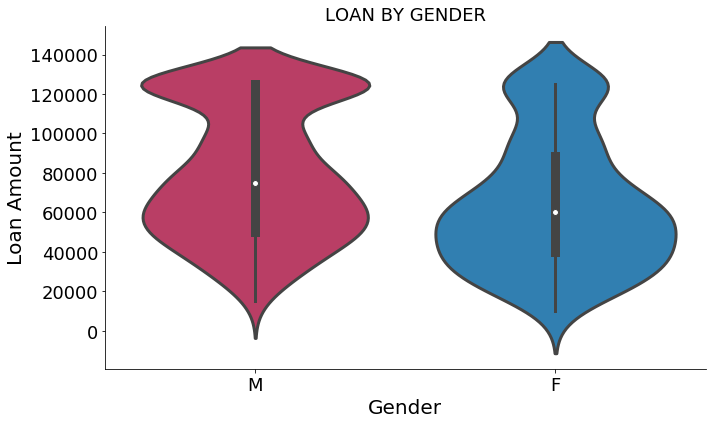

In [46]:
fig = plt.figure(figsize=(10,6))
sns.catplot(x="Gender", y='Loan Amount', kind="violin", data=loans, palette=['#ce295e','#1c84c6'])
plt.title('LOAN BY GENDER', fontsize=18)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
# plt.savefig('LoanByGender.png', bbox_inches='tight')

Bad debts by gender. First by total loans amount

In [47]:
DebtsByGender = loans[['Gender','Loan Amount','Bad Debt Amount']].groupby(['Gender']).sum().astype(int)
DebtsByGender['Bad Debts %'] = (DebtsByGender['Bad Debt Amount']/DebtsByGender['Loan Amount'])\
                               .astype(float).map("{:.1%}".format)
DebtsByGender.head()

,Loan Amount,Bad Debt Amount,Bad Debts %
Gender,,,
F,18110950,2319921,12.8%
M,46922000,8817938,18.8%


The percentage of bad debts is 6% higher for men than for women.
Now let's look at the loans count, a more representative figure

In [48]:
CountLoansByGender = loans[['Gender', 'Loan Amount']].groupby(['Gender']).count()
CountDebtsByGender = bad_loans[['Gender','Bad Debt Amount']].groupby(['Gender']).count()
CountByGender = pd.concat([CountLoansByGender, CountDebtsByGender], axis=1)

In [49]:
CountByGender['Bad Debts %'] = (CountByGender['Bad Debt Amount']/CountByGender['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
CountByGender.rename(columns={'Loan Amount': 'Loan-Count','Bad Debt Amount':'Bad Debts-Count'}, inplace=True)
CountByGender.head()

,Loan-Count,Bad Debts-Count,Bad Debts %
Gender,,,
F,283,49,17.3%
M,587,137,23.3%


The percentage of bad debts by count is also 6% higher for men than for women. Now let's plot it

In [50]:
PaidByGender=pd.crosstab(loans['Gender'],loans['Repaid']) 
PaidByGender

Repaid,N,Y
Gender,,
F,49,234
M,137,450


<Figure size 1008x432 with 0 Axes>

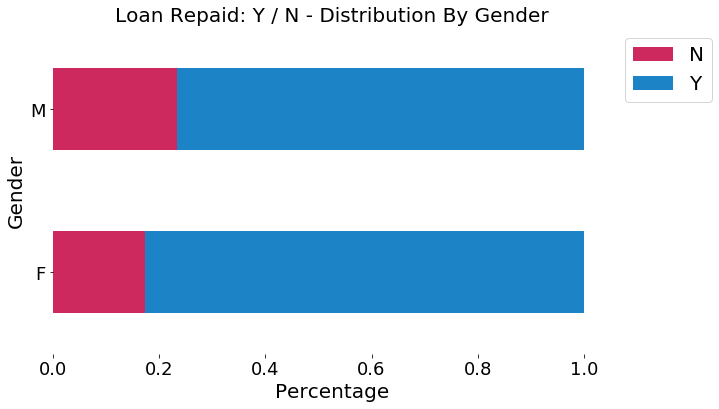

In [51]:
fig = plt.figure(figsize=(14,6))

PaidByGender.div(PaidByGender.sum(1).astype(float), axis=0).plot(kind="barh", stacked=True, color=['#ce295e','#1c84c6'])

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Gender', fontsize=20)
plt.title('Loan Repaid: Y / N - Distribution By Gender')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.gcf().set_size_inches(10, 6)

# plt.savefig('PaidByGenderFig.png', bbox_inches = 'tight')

Loans by status.   First calculate the average loan amount by status

In [52]:
avgLoanByOwnership = loans[['Ownership','Loan Amount']].groupby(['Ownership']).mean().astype(int)
avgLoanByOwnership

,Loan Amount
Ownership,
Multiple Owners,87182
One Owner,69877


Returning resident average loan amount is higher then the immigrant by 24% . 
Lets plot loan amount by status. 

<Figure size 720x432 with 0 Axes>

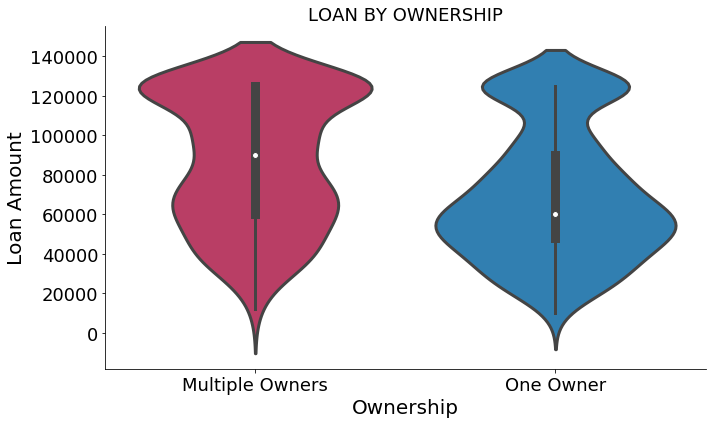

In [53]:
fig = plt.figure(figsize=(10,6))
sns.catplot(x="Ownership", y='Loan Amount', kind="violin", data=loans,  palette=['#ce295e','#1c84c6'])
plt.title('LOAN BY OWNERSHIP', fontsize=18)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
#plt.savefig('LoanByOwnership.png', bbox_inches='tight')

Bad debts by status. First by total loans amount

In [54]:
DebtsByOwnership = loans[['Ownership','Loan Amount','Bad Debt Amount']].groupby(['Ownership']).sum().astype(int)
DebtsByOwnership['Bad Debts %'] = (DebtsByOwnership['Bad Debt Amount']/DebtsByOwnership['Loan Amount'])\
                               .astype(float).map("{:.1%}".format)
DebtsByOwnership.head()

,Loan Amount,Bad Debt Amount,Bad Debts %
Ownership,,,
Multiple Owners,21359800,3080822,14.4%
One Owner,43673150,8057037,18.4%


The percentage of bad debts is 4% higher for One owner than for Mulitple owners.
Now let's look at the loans count, a more representative figure

In [55]:
CountLoansByOwnership = loans[['Ownership', 'Loan Amount']].groupby(['Ownership']).count()
CountDebtsByOwnership = bad_loans[['Ownership', 'Bad Debt Amount']].groupby(['Ownership']).count()
CountByOwnership = pd.concat([CountLoansByOwnership, CountDebtsByOwnership], axis=1)

In [56]:
CountByOwnership['Bad Debts %'] = (CountByOwnership['Bad Debt Amount']/CountByOwnership['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
CountByOwnership.rename(columns={'Loan Amount': 'Loan-Count','Bad Debt Amount':'Bad Debts-Count'}, inplace=True)
CountByOwnership.head()

,Loan-Count,Bad Debts-Count,Bad Debts %
Ownership,,,
Multiple Owners,245,46,18.8%
One Owner,625,140,22.4%


The percentage of bad debts by count is also 4% higher for One owner than for Multiple owners. Now let's plot it

In [57]:
PaidByOwnership=pd.crosstab(loans['Ownership'],loans['Repaid']) 
PaidByOwnership

Repaid,N,Y
Ownership,,
Multiple Owners,46,199
One Owner,140,485


<Figure size 1008x432 with 0 Axes>

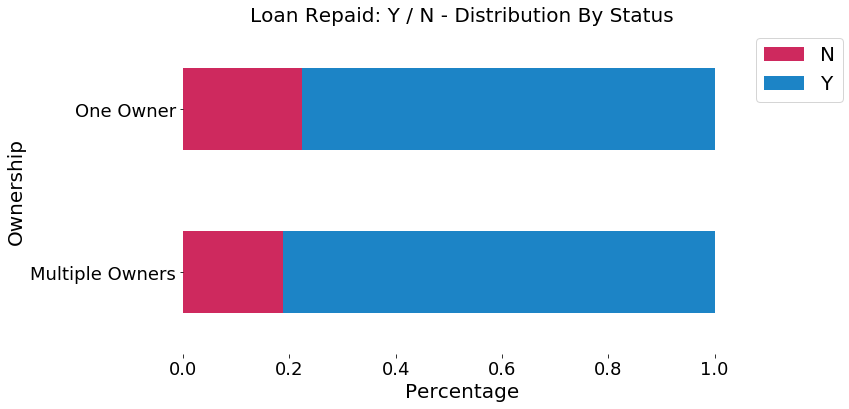

In [58]:
fig = plt.figure(figsize=(14,6))

PaidByOwnership.div(PaidByOwnership.sum(1).astype(float), axis=0).plot(kind="barh", stacked=True, color=['#ce295e','#1c84c6'])

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Ownership', fontsize=20)
plt.title('Loan Repaid: Y / N - Distribution By Status')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.gcf().set_size_inches(10, 6)

#plt.savefig('PaidByOwnershipFig.png', bbox_inches = 'tight')

Loans by age range.   First calculate the average loan amount by age range

In [59]:
avgLoanByAge = loans[['Age Range','Loan Amount']].groupby(['Age Range']).mean().astype(int)
avgLoanByAge

,Loan Amount
Age Range,
20 - 30,68424
30 - 40,74550
40 - 50,76993
50 - 60,75525
60 - 70,83017


The highest average loan amount is at the age range of 60-70  = 83k and the lowest is in the age range of 20-30 = 68k . 
Lets plot loan amount by age range

<Figure size 720x576 with 0 Axes>

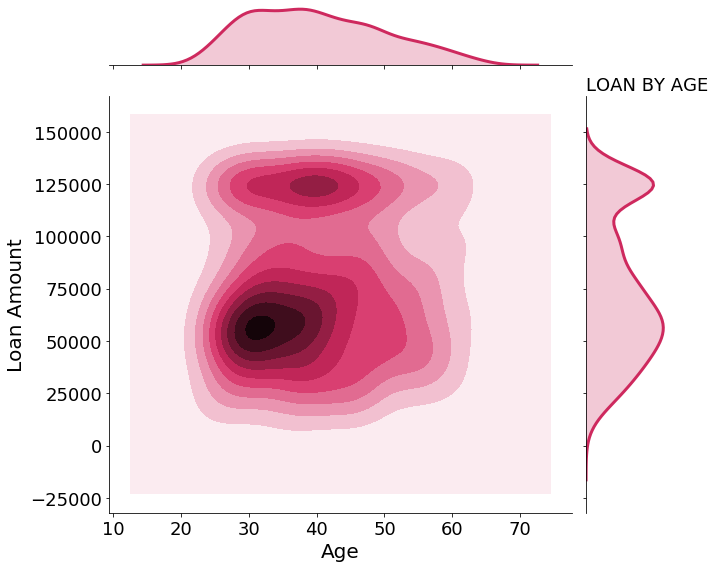

In [60]:
fig = plt.figure(figsize=(10,8))
sns.jointplot(x='Age',y='Loan Amount',data=loans ,kind='kde', color='#ce295e')
plt.title('LOAN BY AGE', fontsize=18, loc='left')
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
# plt.savefig('LoanByAge.png', bbox_inches='tight')

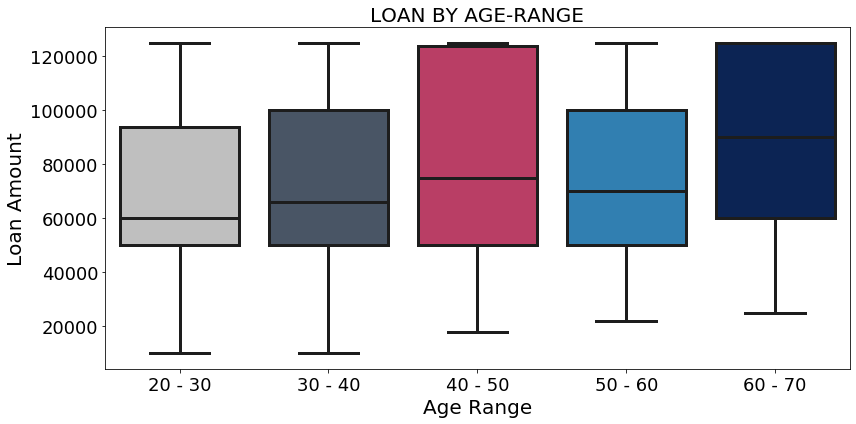

In [61]:
fig = plt.figure(figsize=(12, 6))
sns.boxplot(x='Age Range', y='Loan Amount', data=loans, order=["20 - 30", "30 - 40", "40 - 50","50 - 60","60 - 70"],
                               palette=['#bfbfbf','#44546a','#ce295e','#1c84c6','#002060'])

plt.title('LOAN BY AGE-RANGE', fontsize=20)
plt.gcf().set_size_inches(12, 6)
plt.tight_layout()
# plt.savefig('LoanByAgeRange.png', bbox_inches='tight')

Bad debts by age range. First by total loans amount

In [62]:
DebtsByAge = loans[['Age Range','Loan Amount','Bad Debt Amount']].groupby(['Age Range']).sum().astype(int)
DebtsByAge['Bad Debts %'] = (DebtsByAge['Bad Debt Amount']/DebtsByAge['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
DebtsByAge.head()

,Loan Amount,Bad Debt Amount,Bad Debts %
Age Range,,,
20 - 30,9100500,1715043,18.8%
30 - 40,24005100,3295686,13.7%
40 - 50,19248350,3857030,20.0%
50 - 60,10271500,1971691,19.2%
60 - 70,2407500,298409,12.4%


The highest percentage of 'bad' debts is in the age range of 40-50 , and the lowest is in the age range of 60-70
Lets plot it

<Figure size 720x576 with 0 Axes>

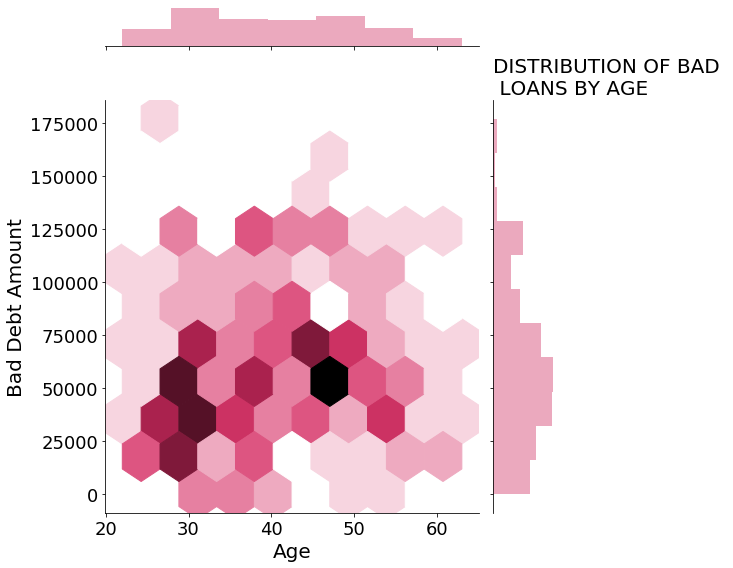

In [63]:
fig = plt.figure(figsize=(10,8))
sns.jointplot(x='Age' ,y='Bad Debt Amount',data=bad_loans, color='#ce295e', kind='hex')
plt.title('DISTRIBUTION OF BAD \n LOANS BY AGE', loc='left')
plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
# plt.savefig('BadDeptsByAge.png', bbox_inches = 'tight')

Now let's look at the loans count, a more representative figure

In [64]:
CountLoansByAge = loans[['Age Range', 'Loan Amount']].groupby(['Age Range']).count()
CountDebtsByAge = bad_loans[['Age Range', 'Bad Debt Amount']].groupby(['Age Range']).count()
CountByAge = pd.concat([CountLoansByAge, CountDebtsByAge], axis=1)

In [65]:
CountByAge['Bad Debts %'] = (CountByAge['Bad Debt Amount']/CountByAge['Loan Amount'])\
                                .astype(float).map("{:.1%}".format)
CountByAge.rename(columns={'Loan Amount': 'Loan-Count','Bad Debt Amount':'Bad Debts-Count'}, inplace=True)
CountByAge.head()

,Loan-Count,Bad Debts-Count,Bad Debts %
Age Range,,,
20 - 30,133,34,25.6%
30 - 40,322,59,18.3%
40 - 50,250,54,21.6%
50 - 60,136,34,25.0%
60 - 70,29,5,17.2%


The highest percentage of 'bad' debts is in the age range of 20-30 , and the lowest is in the age range of 60-70
Lets plot it

In [66]:
PaidByAge=pd.crosstab(loans['Age Range'],loans['Repaid']) 
PaidByAge

Repaid,N,Y
Age Range,,
20 - 30,34,99
30 - 40,59,263
40 - 50,54,196
50 - 60,34,102
60 - 70,5,24


<Figure size 1008x432 with 0 Axes>

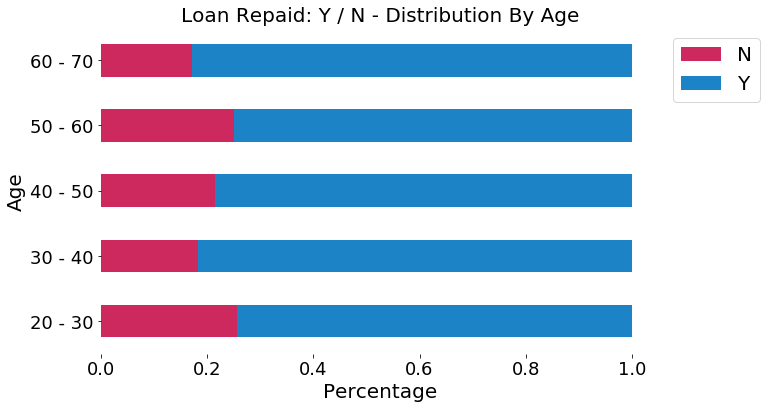

In [67]:
fig = plt.figure(figsize=(14,6))

PaidByAge.div(PaidByAge.sum(1).astype(float), axis=0).plot(kind="barh", stacked=True, color=['#ce295e','#1c84c6'])

for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.xlabel('Percentage', fontsize=20)
plt.ylabel('Age', fontsize=20)
plt.title('Loan Repaid: Y / N - Distribution By Age')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.gcf().set_size_inches(10, 6)

# plt.savefig('PaidByAgeFig.png', bbox_inches = 'tight')

Loans by business location - by country.
Lets plot the major countries that received loans

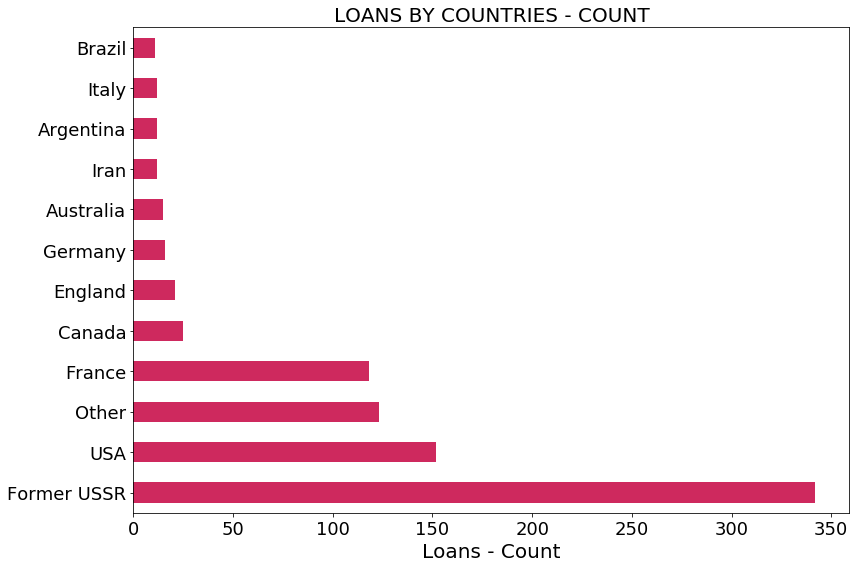

In [68]:
fig = plt.figure(figsize=(12,8))
loans['Country'].value_counts().head(12).plot(kind='barh', color='#ce295e')
plt.xlabel('Loans - Count', fontsize=20)
plt.title('LOANS BY COUNTRIES - COUNT')
plt.gcf().set_size_inches(12, 8)
plt.tight_layout()
# plt.savefig( 'LoansByCountry.png', bbox_inches = 'tight')

The top 3 areas are: Former USSR, USA and France. 
Lets analyze 'bad' debts by country. By loans count. 

In [69]:
CountLoansByCountry = loans[['Country', 'Loan Amount']].groupby(['Country']).count()
CountDebtsByCountry = bad_loans[['Country', 'Bad Debt Amount']].groupby(['Country']).count()
CountByCountry = pd.concat([CountLoansByCountry, CountDebtsByCountry], axis=1).sort_values(by='Loan Amount', ascending=False)
CountByCountry.rename(columns={'Loan Amount': 'Loans - Count', 'Bad Debt Amount': 'Bad Debts - Count'}, inplace=True)

In [70]:
CountByCountry['Bad Debts %'] = (CountByCountry['Bad Debts - Count']/CountByCountry['Loans - Count'] * 100)\
                               .astype(float).round(1)

In [71]:
# Prepare the data for interactive world map plot
worldf = CountByCountry.rename(index={'Former USSR': 'Russia'}).drop('Other').sort_values('Bad Debts %', ascending = False).\
         reset_index()
worldf

,Country,Loans - Count,Bad Debts - Count,Bad Debts %
0,Argentina,12,5,41.7
1,Canada,25,7,28.0
2,Brazil,11,3,27.3
3,France,118,30,25.4
4,USA,152,33,21.7
5,Australia,15,3,20.0
6,Russia,342,67,19.6
7,England,21,4,19.0
8,Ethiopia,11,2,18.2
9,Iran,12,2,16.7


The highest percentage of 'bad' debts is in Argentina , and the lowest is in Italy.
Plot an interactive world map with the data

In [72]:
world_data = dict(
                   type = 'choropleth',
                   colorscale =  'reds',
                   reversescale = False,
                   locations = worldf['Country'],
                   locationmode = "country names",
                   z = worldf['Bad Debts %'],
                   text = worldf['Country'],
                   colorbar = {'title' : '% Bad Debts'}) 

In [73]:
layout = dict(title = '% Bad Debts By Country',
                geo = dict(showframe = False, projection = {'type':'natural earth'}))

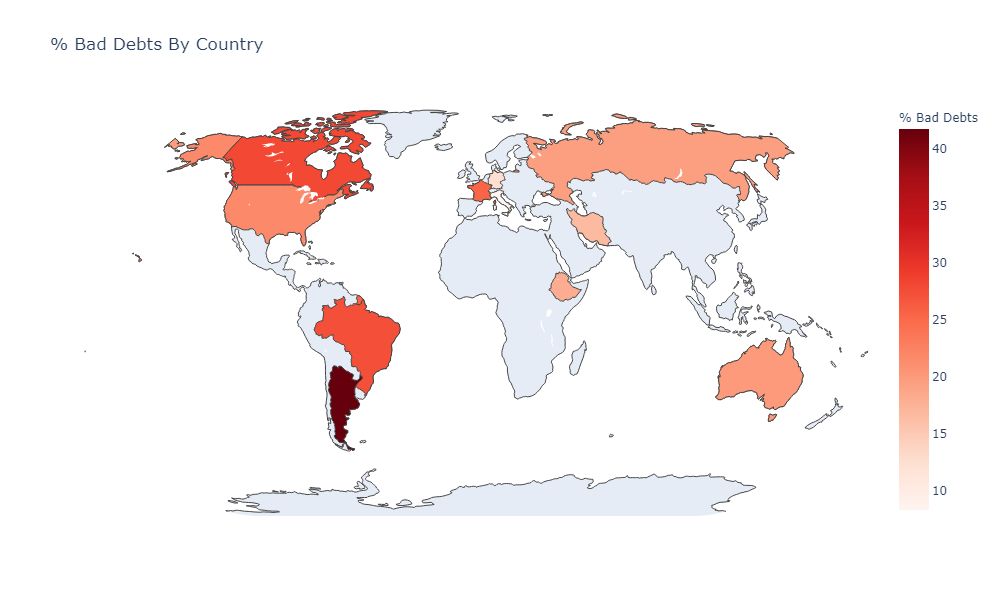

In [74]:
choromap = go.Figure(world_data ,layout)

pio.write_html(choromap, file='map_fig.html',  auto_open=False) # as interactive plot with .html page

# pio.show(choromap) # to display on Jupyter notebook as interactive mode
pio.show(choromap, renderer='png', width=1000, height=600) # to display on github as a static figure

Bad debts by field of business. By loans count. 

In [75]:
CountLoansByFields = loans[['Field', 'Loan Amount']].groupby(['Field']).count()
CountDebtsByFields = bad_loans[['Field', 'Bad Debt Amount']].groupby(['Field']).count()
CountByField = pd.concat([CountLoansByFields, CountDebtsByFields], axis=1).sort_values(by='Loan Amount', ascending=False)
CountByField.rename(columns={'Loan Amount': 'Loans - Count', 'Bad Debt Amount': 'Bad Debts - Count'}, inplace=True)

In [76]:
CountByField['Bad Debts %'] = (CountByField['Bad Debts - Count']/CountByField['Loans - Count'] * 100)\
                               .astype(float).round(1)
CountByField

,Loans - Count,Bad Debts - Count,Bad Debts %
Professional Services,124,26.0,21.0
Food and restaurants,98,38.0,38.8
Marketing,94,23.0,24.5
Cosmetics and Hairdressers,82,9.0,11.0
"Sports, arts and leisure",72,9.0,12.5
Construction and Renovations,54,20.0,37.0
Fashion,48,16.0,33.3
Other,44,6.0,13.6
Medicine,42,1.0,2.4
Production,41,6.0,14.6


In [77]:
bad_fields = CountByField[['Bad Debts %']].sort_values('Bad Debts %', ascending=False)
bad_fields

,Bad Debts %
Food and restaurants,38.8
Construction and Renovations,37.0
Maintenance and cleanliness,36.0
Fashion,33.3
Furniture,27.8
Engineering and Computers,27.3
Marketing,24.5
Professional Services,21.0
Internet,18.2
"Transportation, transport, errands",16.7


The highest percentage of 'bad' debts is in the fiels of 'food and restaurants', and the lowest is in 'Attractions'.
Lets plot the data. 

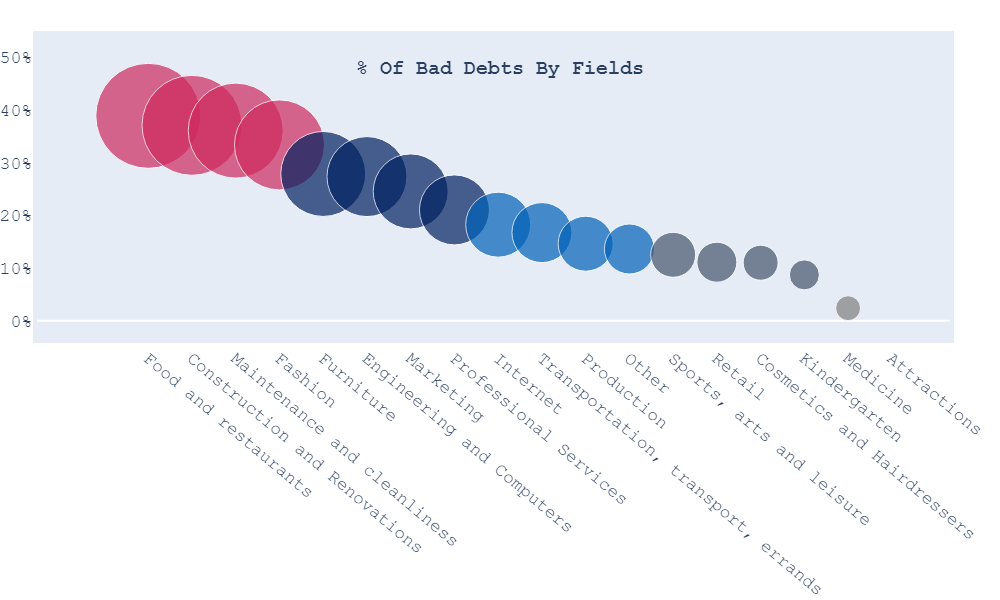

In [78]:
field_data = go.Figure(data=[go.Scatter(
                             x=bad_fields.index,
                             y=bad_fields['Bad Debts %']/100,
                             mode='markers',
                             marker=dict(
                                         color=['#ce295e', '#ce295e','#ce295e','#ce295e',
                                                '#002060','#002060','#002060','#002060',
                                                '#0060b8','#0060b8','#0060b8','#0060b8',
                                                '#44546a','#44546a','#44546a','#44546a',
                                                '#7f7f7f','#7f7f7f','#7f7f7f','#7f7f7f'],
                                         size = list(range(105, 15, -5)),
                                         showscale=False
                                          ))])

fig =go.Figure(data=field_data)

fig.update_layout(
                  autosize=False, width=1000, height=800,
                  title={'text':'<b>% Of Bad Debts By Fields<b>', 'y':0.9, 'x':0.5, 'font': {'size': 20}},
                  xaxis = go.layout.XAxis(tick0 = 2,dtick = 1, tickangle=40, showgrid=False),
                  yaxis = go.layout.YAxis(tickformat = '%', showgrid=False),
                  font=dict(family="Courier New, monospace",size=18),
                  margin=dict(l=0, r=50, b=250, t=35, pad=4))

pio.write_html(fig, file='Scatter_field_fig.html', auto_open=False) # as interactive plot with .html page

# pio.show(fig) # to disply on Jupyter notebook as interactive mode
pio.show(fig, renderer='png', width=1000, height=600) # to display on github as a static figure

Bad debts by business consultant. By loans count. 

In [79]:
CountLoansByConsultants = loans[['Consultant', 'Loan Amount']].groupby(['Consultant']).count()
CountDebtsByConsultants = bad_loans[['Consultant', 'Bad Debt Amount']].groupby(['Consultant']).count()
CountByConsultants= pd.concat([CountLoansByConsultants, CountDebtsByConsultants], axis=1)\
                             .sort_values(by='Loan Amount', ascending=False)
CountByConsultants.rename(columns={'Loan Amount': 'Loans - Count', 'Bad Debt Amount': 'Bad Debts - Count'}, inplace=True)

In [80]:
CountByConsultants['Bad Debts %'] = (CountByConsultants['Bad Debts - Count']/CountByConsultants['Loans - Count'] * 100)\
                               .astype(float).round(1)
CountByConsultants = CountByConsultants.iloc[:15]
CountByConsultants

,Loans - Count,Bad Debts - Count,Bad Debts %
Consultant,,,
Other,185,38,20.5
S.B,103,24,23.3
A.S,73,10,13.7
Z.T,66,14,21.2
Y.S,65,13,20.0
Y.G,61,10,16.4
S.S,60,18,30.0
A.V,52,13,25.0
V.I,37,9,24.3


In [81]:
bad_consultants = CountByConsultants[['Bad Debts %']].sort_values('Bad Debts %', ascending=False)
bad_consultants

,Bad Debts %
Consultant,
T.Z,38.9
Y.B,31.6
S.S,30.0
A.V,25.0
V.I,24.3
S.B,23.3
Z.V,22.7
Y.BY,21.4
Z.T,21.2


Lets plot the data

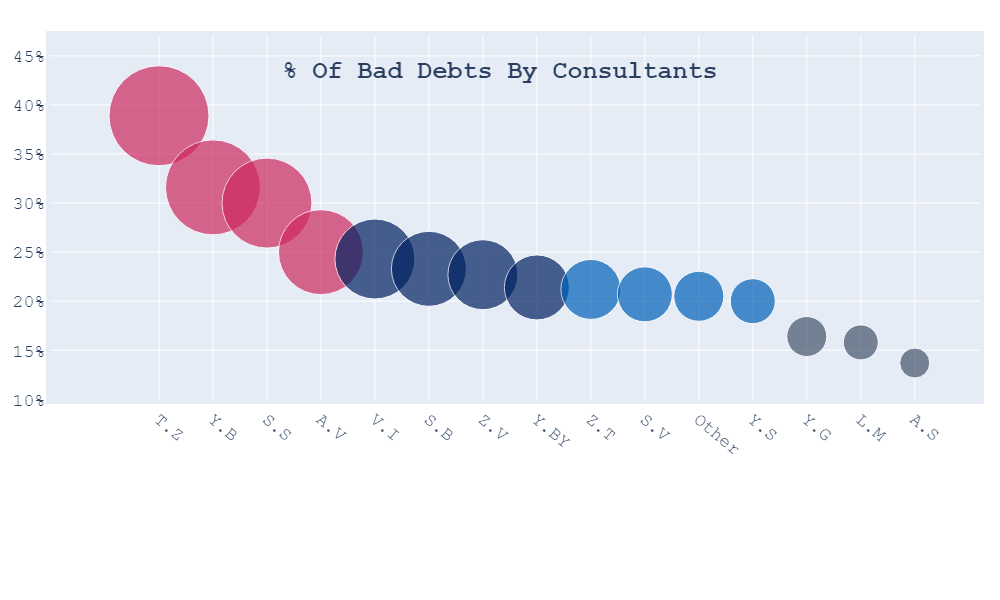

In [82]:
consultants_data = go.Figure(data=[go.Scatter(
                                   x=bad_consultants.index,
                                   y=bad_consultants['Bad Debts %']/100,
                                   mode='markers',
                                   marker=dict(
                                              color=['#ce295e', '#ce295e','#ce295e','#ce295e',
                                                     '#002060','#002060','#002060','#002060',
                                                     '#0060b8','#0060b8','#0060b8','#0060b8',
                                                     '#44546a','#44546a','#44546a','#44546a',
                                                     '#7f7f7f','#7f7f7f','#7f7f7f','#7f7f7f'],
                                              size = list(range(100, 15, -5)),
                                              showscale=False
                                               ))])

fig =go.Figure(data=consultants_data)

fig.update_layout(
                  autosize=False, width=1000, height=800,
                  title={'text':'<b> % Of Bad Debts By Consultants <b>', 'y':0.9, 'x':0.5, 'font': {'size': 25}},
                  xaxis = go.layout.XAxis(tick0 = 2,dtick = 1, tickangle=40),
                  yaxis = go.layout.YAxis(tickformat = '%'),
                  font=dict(family="Courier New, monospace",size=18),
                  margin=dict(l=50, r=20, b=200, t=35, pad=4))
        
pio.write_html(fig, file='Scatter_consultants_fig.html', auto_open=False) # as interactive plot with .html page

# pio.show(fig) # to disply on Jupyter notebook as interactive mode
pio.show(fig, renderer='png', width=1000, height=600) # to display on github as a static figure

# After exploring and analyzing the data, I will use machine learning algorithm on the data and try to predict if a loan will be repaid or is it a 'risky' loan. 

First, copy the original data frame, and take only 'object' and 'category' columns type to train on

In [83]:
categ_data = loans.select_dtypes(include=['object','category']).copy()
categ_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 2010
Data columns (total 10 columns):
District             870 non-null object
Gender               870 non-null object
Ownership            870 non-null object
Age Range            870 non-null object
Country              870 non-null object
Business Status      870 non-null object
Field                870 non-null object
Consultant           870 non-null object
Repaid               870 non-null object
Loan Amount Range    870 non-null category
dtypes: category(1), object(9)
memory usage: 69.0+ KB


Check to see if there are null values. I didn't encounter null values along the data analysis, but I will check anyway

In [84]:
categ_data.isnull().sum()

District             0
Gender               0
Ownership            0
Age Range            0
Country              0
Business Status      0
Field                0
Consultant           0
Repaid               0
Loan Amount Range    0
dtype: int64

# Data Preparation

Change the object and categorical columns types into numeric, before training the model 

In [85]:
# Keep the source of categorical data, and create a copy for different encoding methods
encoded_data = categ_data.copy()

In [86]:
# We have two ordinal categorical. Lets see the values. 
print('Loan Amount Range: ', groups)
print ('Age Range: ', encoded_data['Age Range'].unique())

Loan Amount Range:  ['Very Low', 'Low', 'Medium', 'High', 'Very High']
Age Range:  ['60 - 70' '30 - 40' '20 - 30' '50 - 60' '40 - 50']


In [87]:
# Keep the order of the categories with numeric featuers 
encoder = OrdinalEncoder()
encoded_data[['Loan Amount Range', 'Age Range']] = encoder.fit_transform(encoded_data[['Loan Amount Range', 'Age Range']])\
                                                   .astype(int)

In [88]:
# The rest of the columns are object type.
obj_cols = encoded_data.drop(['Age Range', 'Loan Amount Range'], axis=1).columns

In [89]:
encoded_data[obj_cols] = encoded_data[obj_cols].apply(lambda x: pd.factorize(x)[0])
encoded_data.head()

,District,Gender,Ownership,Age Range,Country,Business Status,Field,Consultant,Repaid,Loan Amount Range
0,0,0,0,4,0,0,0,0,0,3
1,1,0,1,1,1,0,0,1,0,0
2,1,0,1,0,2,1,1,2,0,3
5,1,1,1,1,1,1,2,3,1,2
12,1,1,1,1,3,0,3,0,1,3


In [90]:
encoded_X = encoded_data.drop(['Repaid'], axis=1)
encoded_y = encoded_data['Repaid']

In [91]:
# Pre check
encoded_X.shape[0] == encoded_y.shape[0]

True

# Resample the data to get balanced target values

In [92]:
# First, recall the unbalanced target data
count_Repaid_N, count_Repaid_Y = encoded_data.Repaid.value_counts()
print(count_Repaid_N, count_Repaid_Y)

684 186


In [93]:
# Separate by target value
Repaid_N = encoded_data[encoded_data['Repaid'] == 0]
Repaid_Y = encoded_data[encoded_data['Repaid'] == 1]

In [94]:
# Use random over-sampling to balance the target class of 'N' to the 'Y' before training the data
ros = RandomOverSampler(random_state=1)
X, y = ros.fit_resample(encoded_X, encoded_y)

In [95]:
# Count and recheck if now the target values are balanced
from collections import Counter 
print(sorted(Counter(y).items()))

[(0, 684), (1, 684)]


In [96]:
resampled = pd.DataFrame(data=X, columns=encoded_data.drop('Repaid', axis=1).columns)
resampled['Repaid'] = y

Plot and check if there is correlation between the categories

Text(0.5, 1, 'Correlation Plot')

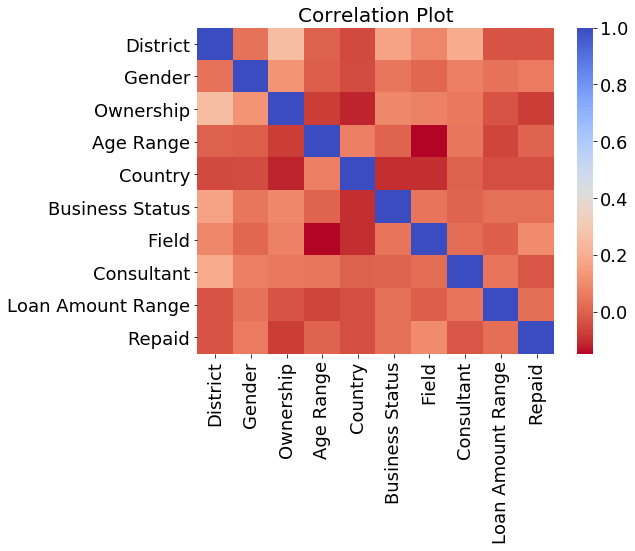

In [97]:
fig = plt.figure(figsize=(8,6))
corr = resampled.corr()
sns.heatmap(corr, cmap="coolwarm_r")
plt.title('Correlation Plot')
# plt.savefig('corr.png', bbox_inches = 'tight')

It seems that there is no correlation between the categories

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

Check the sets shape

In [99]:
print('Training shape: ', X_train.shape)
print('Testing shape: ', X_test.shape)

Training shape:  (1094, 9)
Testing shape:  (274, 9)


# Train different models

In [100]:
 # Print results
def print_report(m_name, trn_accuracy, tst_accuracy, tst_pred):
    print("-"*60)
    print(m_name)
    print ('Train Accuracy: {:.2%}'.format(trn_accuracy))
    print ('Test Accuracy: {:.2%}'.format(tst_accuracy))
    if trn_accuracy > 1.2 * tst_accuracy :
        print(' O V E R  F I T T I N G ')
    print('\n')
    print('\n', classification_report(y_test, tst_pred, target_names=["NO", "YES"]))
    print('\n')

In [101]:
def plot_confusion_matrix(c_m, m_name):
    fig, ax = plt.subplots()
    sns.heatmap(c_m, annot=True, cmap="coolwarm_r", linewidths=1, annot_kws={"size": 30},  fmt="d",
                                      xticklabels=['NO','YES'], yticklabels=['NO','YES'])

    plt.title('Confusion Matrix: {:s}'.format(m_name))
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
#     plt.savefig(m_name+'.png', bbox_inches='tight')

In [102]:
# Save the model as a pickl file for predictions
def pickle_model(name, mdl):
    with open(name+'.pckl', 'wb') as f:
        pickle.dump(mdl, f)

In [103]:
models_dict = {'Logistic regression': LogisticRegression(random_state=42),
              'Decision Tree' : DecisionTreeClassifier(random_state=42),
               'Random Forest' : RandomForestClassifier(random_state=42),
               'SVM' : svm.LinearSVC(random_state=42) }

In [104]:
# Train models
def ml(mdl_dict):
    summary_dict = {}
    for k in mdl_dict:
        model_name = k
        model = mdl_dict[k]
        model.fit(X_train, y_train)
        
        # Create reports to evaluate the models
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, test_pred)
        train_accu = accuracy_score(y_train, train_pred)
        test_accu = accuracy_score(y_test, test_pred)
        precision = precision_score(y_test, test_pred, average='binary')
        recall = recall_score(y_test, test_pred, average='binary')
        score = f1_score(y_test, test_pred, average='binary')
        
        summary_dict[k] = [test_accu, precision, recall, score]
        
        # Print , plot and pickle
        print_report(model_name, train_accu, test_accu, test_pred)
        plot_confusion_matrix(cm, model_name)
        pickle_model(model_name, model)
        
    # Summary report for comparing models results
    summary = pd.DataFrame(summary_dict.values(), columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                           index=summary_dict.keys()).round(2)
    print ('Summary Of Models Scores ')
    print ('-'*60)
    print (summary)

# Train different models

------------------------------------------------------------
Logistic regression
Train Accuracy: 56.58%
Test Accuracy: 55.11%



               precision    recall  f1-score   support

          NO       0.52      0.57      0.54       128
         YES       0.59      0.53      0.56       146

    accuracy                           0.55       274
   macro avg       0.55      0.55      0.55       274
weighted avg       0.55      0.55      0.55       274



------------------------------------------------------------
Decision Tree
Train Accuracy: 98.99%
Test Accuracy: 80.66%
 O V E R  F I T T I N G 



               precision    recall  f1-score   support

          NO       0.72      0.95      0.82       128
         YES       0.94      0.68      0.79       146

    accuracy                           0.81       274
   macro avg       0.83      0.82      0.81       274
weighted avg       0.84      0.81      0.80       274



------------------------------------------------------------
Ra

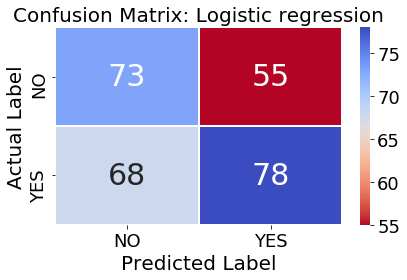

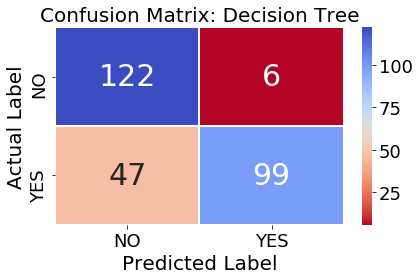

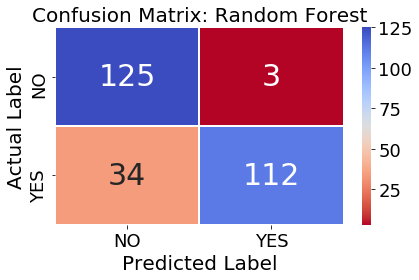

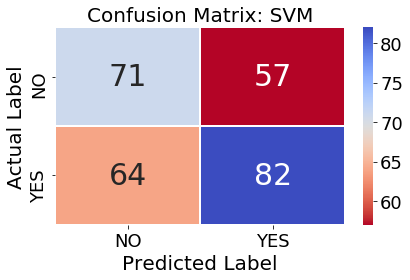

In [105]:
ml(models_dict)

# Best model seems to be Random Forest
# Try another model -  KNN

In [106]:
def print_knn(k, precision, recall, score, trn_accuracy, tst_accuracy, tst_pred, cm, mdl):
    print('Summary Of KNN Model Scores with K = {:d}'.format(k))      
    print ('Precision {:.2%}'.format(precision))
    print ('Recall  {:.2%}'.format(recall))
    print ('F1 Score {:.2%}'.format(score))
    print('\n')
    print ('Train Accuracy: {:.2%}'.format(trn_accuracy))
    print ('Test Accuracy: {:.2%}'.format(tst_accuracy))
    if trn_accuracy > 1.2 * tst_accuracy :
        print('O V E R  F I T T I N G ')
    print('\n', classification_report(y_test, tst_pred, target_names=["NO", "YES"]))
    
    plot_confusion_matrix(cm, 'KNN')
    pickle_model('KNN', mdl)

In [107]:
# Knn model with k of minimum error rate
def knn_model(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    
    # Create reports to evaluate the models
    train_pred = knn.predict(X_train)
    test_pred = knn.predict(X_test)
    cm = confusion_matrix(y_test, test_pred)
    train_accu = accuracy_score(y_train, train_pred)
    test_accu = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred, average='binary')
    recall = recall_score(y_test, test_pred, average='binary')
    score = f1_score(y_test, test_pred, average='binary')
    
    print_knn(k, precision, recall, score, train_accu, test_accu, test_pred, cm, knn)

In [108]:
def plot_error_rate(err_rates):
    keys , vals = zip(*sorted(err_rates.items()))
    min_k = min(err_rates, key=err_rates.get)
    
    print('K of minimum error rate is: {:d}'.format(min_k))
    
    plt.figure(figsize=(10,6))
    plt.plot(keys, vals, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')   
    
    knn_model(min_k)

In [109]:
# Use the elbow method to pick a good K Value:
def elbow_method(a, b, c):
    error_rate = {}
    for k in range(a, b, c):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train,y_train)
        pred_k = knn.predict(X_test)
        error_rate[k] = np.mean(pred_k != y_test)
               
    plot_error_rate(error_rate)

K of minimum error rate is: 1
Summary Of KNN Model Scores with K = 1
Precision 95.33%
Recall  69.86%
F1 Score 80.63%


Train Accuracy: 98.45%
Test Accuracy: 82.12%

               precision    recall  f1-score   support

          NO       0.74      0.96      0.83       128
         YES       0.95      0.70      0.81       146

    accuracy                           0.82       274
   macro avg       0.84      0.83      0.82       274
weighted avg       0.85      0.82      0.82       274



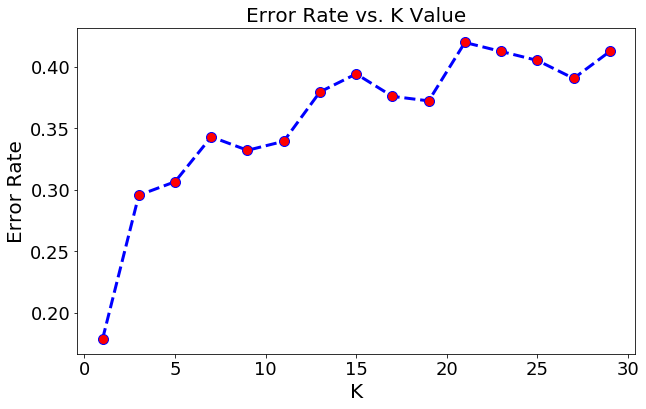

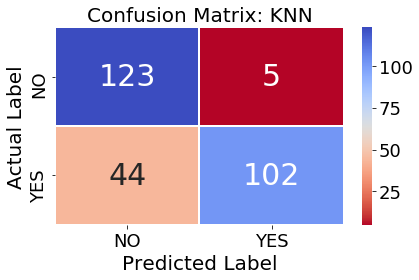

In [110]:
elbow_method(1, 30, 2)

# KNN model doesn't give better results than the random forest model
# I will stick to the Random Forest model, and try to improve it

In [111]:
def print_model(tst_accuracy, precision, recall, score, cm, name, mdl):
    print('Summary Of Random Forest Model Scores') 
    print ('Accuracy {:.2%}'.format(tst_accuracy))
    print ('Precision {:.2%}'.format(precision))
    print ('Recall  {:.2%}'.format(recall))
    print ('F1 Score {:.2%}'.format(score))
    print('\n')
    
    plot_confusion_matrix(cm, name)
    pickle_model(name,mdl )

In [112]:
# Train a single model
def ml_model(model_name, model):
    model.fit(X_train, y_train)
    # Create reports to evaluate the models
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, test_pred)
    train_accu = accuracy_score(y_train, train_pred)
    test_accu = accuracy_score(y_test, test_pred)
    precision = precision_score(y_test, test_pred, average='binary')
    recall = recall_score(y_test, test_pred, average='binary')
    score = f1_score(y_test, test_pred, average='binary')
    
    print_model(test_accu, precision, recall, score, cm, model_name, model)

In [113]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)

Random Search for optimal hyper-parameters

In [114]:
# Set parameters and distributions to sample from
from scipy.stats import randint  # Initialize random values for the parameters below.
param_dist = { 
    'n_estimators': randint(100, 200),
    'max_features': randint(1, 10.5),
    'max_depth' : [2,3,4,5, None],
    'min_samples_split' : randint(2,11),
    'min_samples_leaf' : randint(1,11),
    'criterion' :['gini', 'entropy'],
    'bootstrap' : [True, False],
}

In [115]:
# Search randomly with parameters above. Takes some time. after getting the result, I marked it as a comment
"""
random_rf  = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_rf.fit(X, y)
from pprint import pprint # For better printing
pprint('Best parameters for the the Random Forest Tree model are  {}'.format(random_rf.best_params_))
"""

"\nrandom_rf  = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)\nrandom_rf.fit(X, y)\nfrom pprint import pprint # For better printing\npprint('Best parameters for the the Random Forest Tree model are  {}'.format(random_rf.best_params_))\n"

In [116]:
print('Fitting 5 folds for each of 100 candidates, totalling 500 fits')
print('Best parameters for the the Random Forest Tree model are')
print('n_estimators: 101')
print('max_features: 1') 
print('max_depth: None')
print('min_samples_split: 4')
print('min_samples_leaf: 1')
print('criterion: entropy')
print('bootstrap: False')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for the the Random Forest Tree model are
n_estimators: 101
max_features: 1
max_depth: None
min_samples_split: 4
min_samples_leaf: 1
criterion: entropy
bootstrap: False


Random Forest Model with default parameters
--------------------------------------------------
Summary Of Random Forest Model Scores
Accuracy 89.78%
Precision 96.83%
Recall  83.56%
F1 Score 89.71%


Random Forest Model with tuned parameters
--------------------------------------------------
Summary Of Random Forest Model Scores
Accuracy 88.69%
Precision 93.89%
Recall  84.25%
F1 Score 88.81%




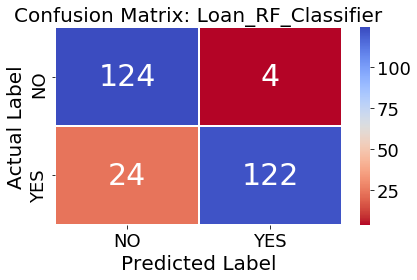

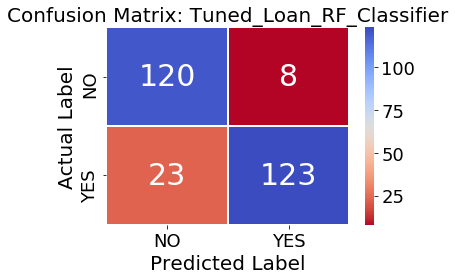

In [117]:
# Tune Random Forest model with best parameters and compare the results with the default parameters in the model
tuned_rf = RandomForestClassifier(n_estimators=101,
                                 criterion='entropy',
                                 max_depth=None,
                                 min_samples_split=4,
                                 min_samples_leaf=1,
                                 max_features=1,
                                 bootstrap='False',
                                 random_state=42)
print ('Random Forest Model with default parameters')
print ('-'*50)
default_rf = ml_model('Loan_RF_Classifier', rf) # With default parameters
print ('Random Forest Model with tuned parameters')
print ('-'*50)
tunedRF = ml_model('Tuned_Loan_RF_Classifier', tuned_rf)

# Model with the tuned parameters produce a better recall - by ~2%
# But on the default parameters produce beter Precision by ~3% 

# In risk management, one should ask which error will cost more ... In this case, the loan approval cost, which is then not repaid, is higher than the cost of not approving a loan, that would have been repaid. So Random Forest Model with default parameters is the best model in this case.

Which are the most important features in the model

In [118]:
feature_importances = pd.DataFrame(tuned_rf.feature_importances_, index=resampled.columns.drop('Repaid'),
                                   columns=['Importance']).sort_values('Importance', ascending=False)

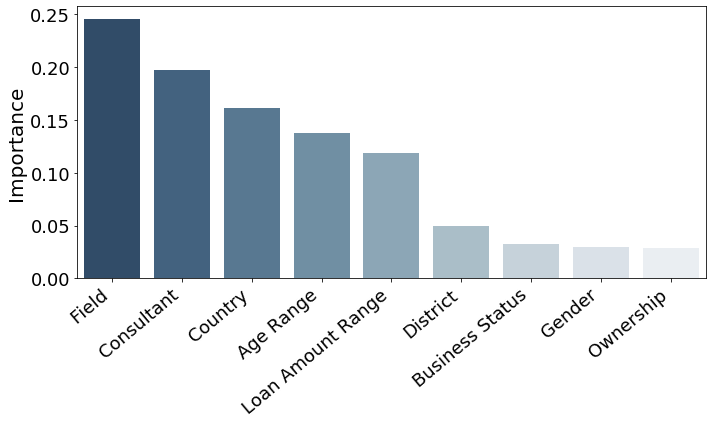

In [119]:
fig = plt.figure(figsize=(10,6))
ax = sns.barplot(x=feature_importances.index, y='Importance', data=feature_importances, palette='Blues_r', saturation=0.4)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
# plt.savefig('importanceFeatures.png', bbox_inches = 'tight')

In [120]:
encoded_data = encoded_data.rename(columns={'District':'District_Code', 'Gender':'Gender_Code', 'Ownership':'Ownership_Code',
                            'Age Range': 'Age_Code', 'Country':'Country_Code', 'Business Status':'Business_Code',
                            'Field':'Field_Code', 'Consultant':'Consultant_Code','Loan Amount Range':'Loan_Amount_Code'})

In [121]:
loans_df = pd.concat([categ_data,encoded_data],axis=1).drop('Repaid', axis=1)
loans_df.head()

,District,Gender,Ownership,Age Range,Country,Business Status,Field,Consultant,Loan Amount Range,District_Code,Gender_Code,Ownership_Code,Age_Code,Country_Code,Business_Code,Field_Code,Consultant_Code,Loan_Amount_Code
0,North,M,Multiple Owners,60 - 70,USA,New Business,Food and restaurants,Other,Very High,0,0,0,4,0,0,0,0,3
1,Center,M,One Owner,30 - 40,Former USSR,New Business,Food and restaurants,S.S,High,1,0,1,1,1,0,0,1,0
2,Center,M,One Owner,20 - 30,Iran,Old Business,Fashion,M.G,Very High,1,0,1,0,2,1,1,2,3
5,Center,F,One Owner,30 - 40,Former USSR,Old Business,Other,A.S,Medium,1,1,1,1,1,1,2,3,2
12,Center,F,One Owner,30 - 40,England,New Business,Production,Other,Very High,1,1,1,1,3,0,3,0,3


In [122]:
loans_df.to_pickle('loans_df')